In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import matplotlib.patheffects as PathEffects

### load lidar xarray

In [2]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU
#~~~~ ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()

#~~~~ ds peak
dpeak = ds.isel(time=[0,7,18,30,42,49]) #0,7,22,28,41,49]
dpeak.close()

ds = dpeak
ds.close()

### load terrain xarray

In [7]:
path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/terrain/*.nc' #ARS
# path = '/Users/meganmason491/Documents/research/sierra/data/terrain/*.nc' #BSU
fpath = glob.glob(path)
fpath


['/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/terrain/hillshade.nc',
 '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/terrain/slope.nc',
 '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/terrain/aspect.nc']

In [9]:
terrain=xr.open_mfdataset(fpath, concat_dim=None, chunks={'x':1000, 'y':1000}, parallel=True).rename({'Band1':'hillshade'}).drop('transverse_mercator') #combine='nested', 
terrain.close()
terrain

<xarray.Dataset>
Dimensions:    (x: 17569, y: 17002)
Coordinates:
  * x          (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y          (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Data variables:
    hillshade  (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    slope      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    aspect     (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.2.3, released 2017/11/20
    history:      Thu Oct 03 11:41:53 2019: GDAL Create( hillshade.nc, ... )

### flatten

In [10]:
#terrain
dem_flat = ds.dem.values.flatten()
asp_flat = terrain.aspect.values.flatten() # subtract 45 degrees so range is -45:345 (i.e N[-45:45], E[46:])
slp_flat = terrain.slope.values.flatten()

In [12]:
dem_flat = dem_flat[::100000] #100,000 of 300,000,000 values = .001% of data
asp_flat = asp_flat[::100000]
slp_flat = slp_flat[::100000]

In [34]:
dem_flat = np.where(dem_flat>0, dem_flat, np.nan)

In [13]:
print(dem_flat.shape)
print(asp_flat.shape)
print(slp_flat.shape)

(2988,)
(2988,)
(2988,)


/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Slope (deg)')

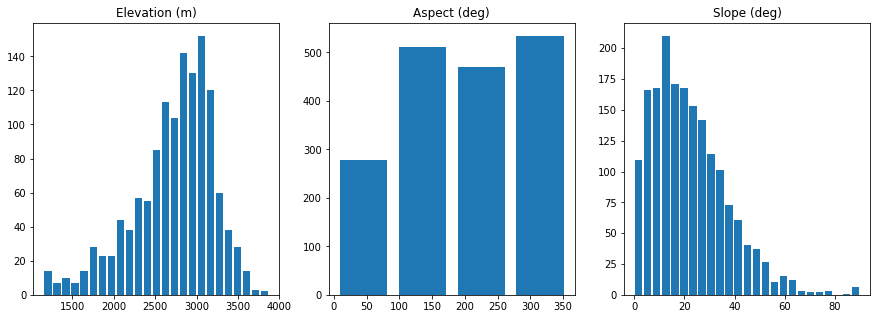

In [14]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(15,5))
ax1.hist(dem_flat, bins=25, rwidth=0.8,  label='elevation'); ax1.set_title('Elevation (m)')
ax2.hist(asp_flat, bins=([0,90,180,270,360]), rwidth=0.8,  label='aspect'); ax2.set_title('Aspect (deg)')
ax3.hist(slp_flat[slp_flat>0], bins=25, rwidth=0.8,  label='slope'); ax3.set_title('Slope (deg)')

9.777853328245762


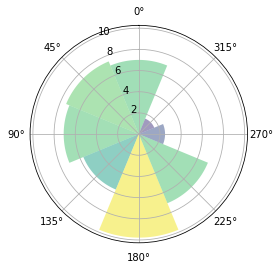

In [18]:
np.random.seed(19680801)

# Compute pie slices
N = 8
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
#theta = np.array([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi])
N = len(theta)
radii = 10 * np.random.rand(N)
print(radii.max())
width = 2* np.pi / N
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(111, projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)
ax.set_theta_zero_location("N")


plt.show()

In [ ]:
# data
yrly_means = ds.snow.groupby('time.year').mean(dim=('x','y')) # snow values grouped by year, then the mean
yrly_means = yrly_means.values.flatten()

print(yrly_means.shape)

# yrly_std = ds.snow.groupby('time.year').std('time')
# yrly_std = yrly_means.values.flatten()

# print(yrly_std.shape)

In [ ]:
plt.plot(ds.time, yrly_means, marker= 'x')

In [19]:
d = []
for layer in list(ds.snow.groupby('time.year')): #.groups:
    print('grouped item', layer)
    
    

grouped item (2013, <xarray.DataArray 'snow' (time: 6, y: 17002, x: 17569)>
dask.array<getitem, shape=(6, 17002, 17569), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2013-06-08
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>)
grouped item (2014, <xarray.DataArray 'snow' (time: 11, y: 17002, x: 17569)>
dask.array<getitem, shape=(11, 17002, 17569), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 417

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/xarray/core/common.py:608: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


### plot

In [26]:
snow=ds.snow.values
print(snow.shape)
# s=snow.values[::10000]
# s

KeyboardInterrupt: 

In [28]:
ds

<xarray.Dataset>
Dimensions:  (time: 6, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 17923

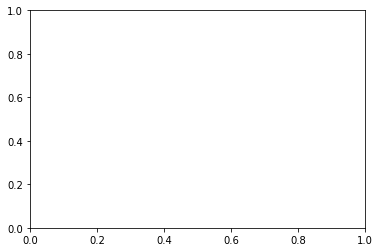

In [30]:
for year in ds.groupby('time.year'):
    a=ds.snow.values.flatten()
    a=a[::100000]
    print(a.shape)
    b=ds.dem.values.flatten()
    b=a[::100000]
    print(b.shape)
#     plt.hexbin(b,a,mincnt=1)
#     plt.show

In [ ]:

# fig = plt.figure(figsize=(15, 10))
# plt.hexbin(dem_flat, yrly_means, mincnt=1)
# plt.xlabel('Elevation [m]')
# plt.ylabel('$\sigma$')
# plt.title('Snow depth [50m] STD by elevation')
# plt.colorbar()
# plt.show()
# plt.savefig('figs/elevation_density_13-16', dpi=600)

In [48]:
a=ds.snow[0].values.flatten()
a=a[::100000]
print(a.shape)
a[a<=0]=np.nan
# b=ds.dem.values.flatten()
# b=a[::100000]
# print(b.shape)

(2988,)


ValueError: cannot convert float NaN to integer

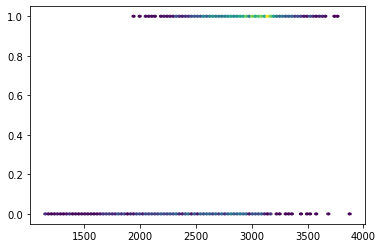

In [47]:
plt.hexbin(dem_flat, a>0, mincnt=1)

In [43]:
print(np.nanmin(dem_flat))

1150.28
